# Annotation Analysis and Consensus

In [7]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from itertools import chain
import scipy as sc
from bct.algorithms import community_louvain
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from krippendorff import alpha
import pingouin as pg

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

In [8]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [9]:
# Loading seizure level metadata
sz_metadata = pd.read_csv(ospj(datapath,'stim_seizure_information - Revised_seizure_annotation.csv'))
sz_metadata.replace({np.nan:pd.NA},inplace=True)

## Seizure Annotator Analysis

### Preparing annotation table

In [10]:
annotators = np.sort(['EC','CK','DZ','JJ','JK'])
time_labels = ['UEO_time']
clinician_tables = {}
for clin in annotators:
    # Load in full annotaiton push
    annot_table = pd.read_csv(ospj(datapath,f"stim_seizure_annotations_{clin}.csv"))
    # Load in annotations from initial assessment
    demo_table = pd.read_csv(ospj(datapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
    demo_table.columns = [c if c != 'Onset' else 'approximate_onset' for c in demo_table.columns]
    clinician_tables[clin] = []
    clinician_tables[clin].append(annot_table)
    clinician_tables[clin].append(demo_table)
# clin_table_list = {df for sublist in clinician_tables for df in sublist]
df_list = [df for l in clinician_tables.values() for df in l]
key_list = np.array([[key]*2 for key in clinician_tables.keys()]).flatten()
combined_df = pd.concat(df_list, keys=key_list, names=['Clinician'])

# Reset index to avoid having MultiIndex
combined_df.reset_index(inplace=True)

# Drop nan rows from csv loading
combined_df = combined_df.dropna(axis=0,how='any',subset=['UEO_ch'])

# Create a unique identifier for each seizure
combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(int).astype(str)
combined_df = combined_df.drop(['level_1'],axis=1)


# Turning strings of channels to a list
combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')

# combined_df.head(5)

In [11]:
# Combining annotations across a patient at the channel level
def combine_ch_annots(group):
    ret = {"clinician": [],
           "patient": [],
        #    "eec": [],
        #    "eec_time": [],
           "ueo": [],
           "ueo_time": [],
           "sec": [],
        #    "spread": []
          }    
    group.sort_values(by='Clinician',inplace=True)
    group['IEEGname'] = group['IEEGname'].fillna(method='ffill').fillna(method='bfill')
    ieeg_name = group['IEEGname'].iloc[0]
    pt = group['patient'].iloc[0]
    # Get all channels
    with open('woj_ieeglogin.bin', 'r') as f:
        session = Session('wojemann', f.read())
    ds = session.open_dataset(ieeg_name)
    raw_labels = clean_labels(ds.get_channel_labels(),pt)
    
    all_chs = remove_scalp_electrodes(raw_labels)
    # group.[group.isna()] = []
    for _,row in group.iterrows():
        for i,v in row.items():
            if not isinstance(v,list):
                if pd.isna(v):
                    row[i] = []
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        # ret["eec"].append([l in clean_labels(row.EEC_ch,pt) for l in all_chs])
        ret["ueo"].append([l in clean_labels(row.UEO_ch,pt) for l in all_chs])
        ret["sec"].append([l in clean_labels(row["10sec_ch"],pt) for l in all_chs])
        # ret["spread"].append([l in clean_labels(row.spread_ch,pt) for l in all_chs])
        # ret["eec_time"].append(row.EEC_time)
        ret["ueo_time"].append(float(row.UEO_time))
    ret["all_chs"] = all_chs
    ret["iEEG_ID"] = row["IEEGname"]
    ret["approximate_onset"] = row["approximate_onset"]
    ret["offset"] = row["end"]
    ret["stim"] = row["stim"]
        
    return pd.Series(ret)

In [12]:
combined_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()

KeyboardInterrupt: 

In [ ]:
combined_annots_reduced = combined_annots[combined_annots.clinician.apply(lambda x: len(x)) > 2]
combined_annots_reduced.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[2528.42, 2528.48, 2531.24]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_005,2528.51,2553.68,1.0
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, False, False, True, Tru...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[DC01, LA01, LA10, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0


### Calculating clinician kappas

In [ ]:
# Calculate the kappa value between each pair of clinicians for each patient
def pairwise_kappa(row):
    row_idxs = [i for i in row.index if i in ["ueo","sec"]]
    for ch_type in row_idxs:
        all_kappas = np.ones((len(row[ch_type]),len(row[ch_type])))*2
        chs = row[ch_type]
        for i in range(len(chs)):
            for j in range(i+1,len(chs)):
                all_kappas[i,j] = cohen_kappa_score(chs[i],chs[j])
                if ch_type == 'ueo':
                    ANNOT_ALL_SZ[row.clinician[i]].append(all_kappas[i,j])
                    ANNOT_ALL_SZ[row.clinician[j]].append(all_kappas[i,j])
        # plt.figure()
        # sns.heatmap(all_kappas,annot=True,fmt=".2f",cmap="magma",xticklabels=row.clinician,yticklabels=row.clinician,vmin=0,vmax=1)
        # plt.title(f"{row.name}: {ch_type}")
        row[f"{ch_type}_kappas"] = all_kappas

    return row

In [ ]:
def plot_kappas_by_clinician(ANNOT_ALL_SZ):
    max_length = max(len(arr) for arr in ANNOT_ALL_SZ.values())
    for key in ANNOT_ALL_SZ.keys():
        ANNOT_ALL_SZ[key] += [np.nan] * (max_length - len(ANNOT_ALL_SZ[key]))
        # ANNOT_ALL_SZ[key] = np.pad(ANNOT_ALL_SZ[key].astype(float), (0, max_length - len(ANNOT_ALL_SZ[key])), 'constant', constant_values=(np.nan,))
    plotting_df = pd.DataFrame.from_dict(ANNOT_ALL_SZ).melt()
    sns.boxplot(plotting_df,x='variable',y='value',palette='flare')
    # plt.xticks(np.arange(len(annotators)),annotators)
    plt.title("UEO Cohen's Kappa by Annotator")
    plt.ylabel('Cohen\'s Kappa')
    plt.xlabel('Clinician Annotator')
    # plt.ylim([0,1.1])

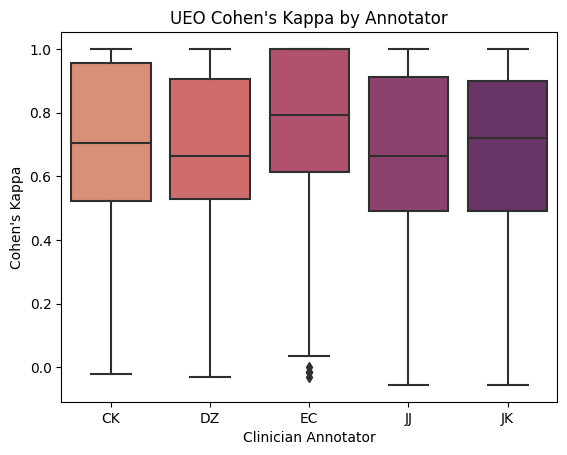

In [ ]:
# All
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots = combined_annots_reduced.apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

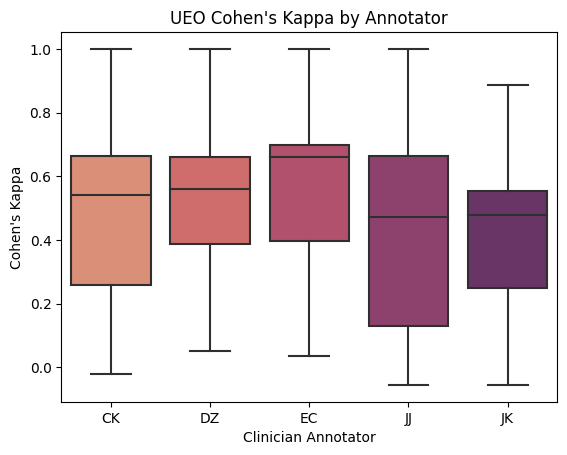

In [ ]:
# CHOP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_chop = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) == 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

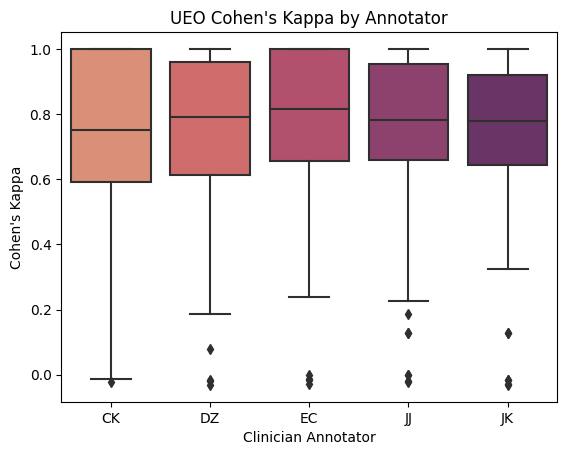

In [ ]:
# HUP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_hup = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) != 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

### Calculating seizure level agreement

In [ ]:
def sz_level_agreement(row):
    row_idxs = [i for i in row.index if 'kappas' in i]
    for chtype in row_idxs:
        row[f"{chtype[:-7]}_avg"] = np.mean(row[chtype][row[chtype] != 2])
    return row
kappa_avg = kappa_annots.apply(sz_level_agreement,axis=1)
kappa_avg.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_kappas,sec_kappas,ueo_avg,sec_avg
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[2528.42, 2528.48, 2531.24]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_005,2528.51,2553.68,1.0,"[[2.0, 0.7444444444444445, 0.6584158415841583]...","[[2.0, 0.4247003647733195, 0.5689424364123159]...",0.763000,0.507648
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[[2.0, 0.6998880179171332, 0.5235555555555556]...","[[2.0, 0.9483423284502699, 0.7625797306874558]...",0.591092,0.842662
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[[2.0, -0.013850415512465464, -0.0149750415973...","[[2.0, 0.5009439899307742, 0.5481481481481482]...",-0.028150,0.516875
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, False, False, True, Tru...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[[2.0, 1.0, 0.3920265780730897], [2.0, 2.0, 0....","[[2.0, 0.4748923959827833, 0.7569721115537849]...",0.594684,0.530916
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[DC01, LA01, LA10, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[[2.0, 0.4806866952789699, -0.0202360876897131...","[[2.0, 0.0, nan], [2.0, 2.0, 0.0], [2.0, 2.0, ...",0.268799,NaN


Text(0.5, 1.0, "Average Channel Agreement (Cohen's Kappa) per Seizure")

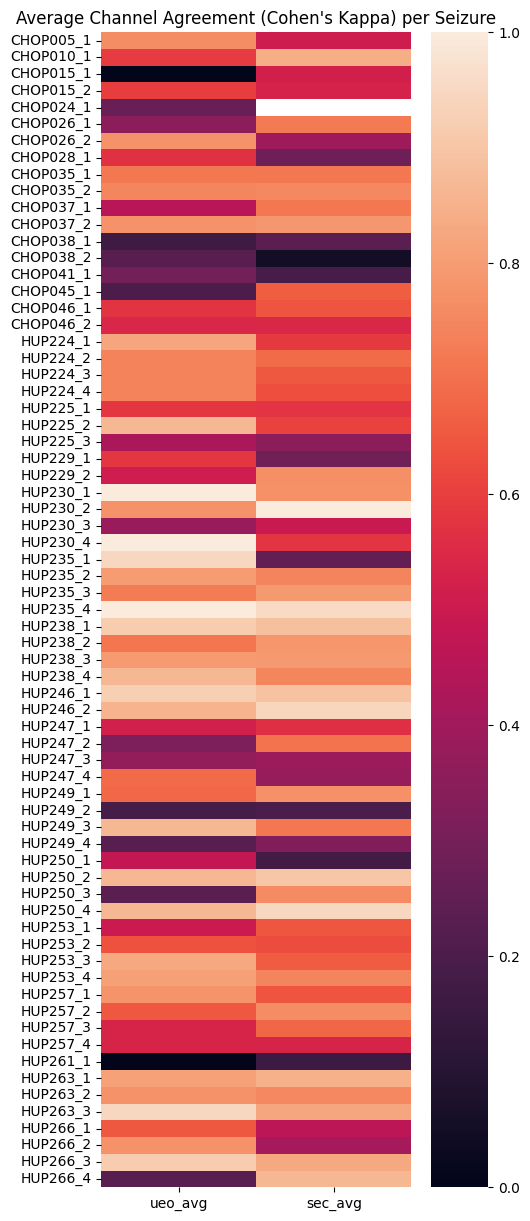

In [ ]:
fig,ax = plt.subplots(figsize=(5,15))
# fig.figsize = (15,5)
sns.heatmap(kappa_avg.iloc[:,-2:],yticklabels=kappa_avg.Seizure_ID,vmin=0,vmax=1)
plt.title("Average Channel Agreement (Cohen\'s Kappa) per Seizure")

### Creating clinician consensus

In [ ]:
def create_consensus(row):
    for key in ["ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 2).astype(bool)
        row[f"{key}_any"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 1).astype(bool)
        if key == 'ueo':
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

In [ ]:
consensus_annots = combined_annots.apply(create_consensus,axis=1)
consensus_annots.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[2528.42, 2528.48, 2531.24]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_005,2528.51,2553.68,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2528.48,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, False, False, True, Tru...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, False, False, True, True...","[False, False, False, False, True, True, True,..."
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[DC01, LA01, LA10, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, True, True..."


In [ ]:
# consensus_annots.to_csv(ospj(prodatapath,"stim_seizure_information_consensus.csv"),index=False)
# consensus_annots.to_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))

## Manual annotation analysis

In [13]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
consensus_annots.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[2528.42, 2528.48, 2531.24]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_005,2528.51,2553.68,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2528.48,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, False, False, True, Tru...","[DC01, DC07, LA01, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, False, False, True, True...","[False, False, False, False, True, True, True,..."
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[DC01, LA01, LA10, LA02, LA03, LA04, LA05, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, True, True..."


MannwhitneyuResult(statistic=353.0, pvalue=0.0005969969641447577)


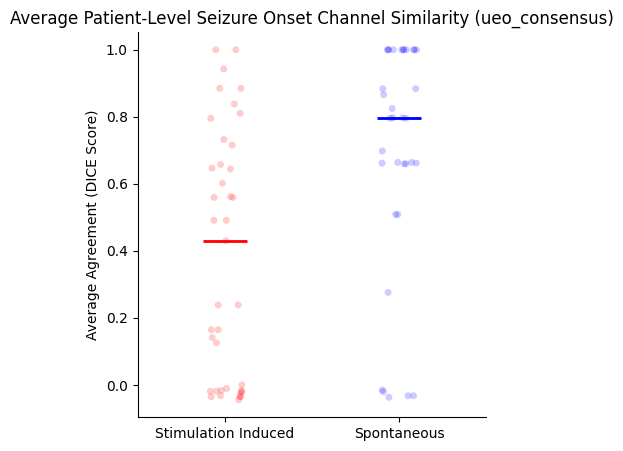

In [14]:
# Can also toggle median or mean within patients
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'consensus'
for pt,group in consensus_annots.groupby("patient"):
    # if sum(group.stim == 0) < 2:
    #     print(f"Skipping {pt} due to insufficient manually annotated spontaneous seizures")
    #     continue
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        ch_mask = group.loc[i,f'{annot_type}_{con_type}']
        # print(ch_mask)
        chs = np.array(group.loc[i,'all_chs'])[ch_mask]
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            ch_mask2 = group.loc[j,f'{annot_type}_{con_type}']
            chs2 = np.array(group.iloc[j,6])[ch_mask2]
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_dices.append(dice_score(chs,chs2))
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_dices.append(dice_score(chs,chs2))
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
    # plt.figure()
    # cols=['red','blue']
    # for i,dist in enumerate([stim_dices,spont_dices]):
    #     sns.stripplot(x=np.ones(len(dist))*i,y=dist,color=cols[i])
    # plt.title(pt)
    # plt.ylim([-.1,1.1])
    # plt.xlim([-.5,1.5])
    # plt.ylabel('DICE Score (agreement)')
    # plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
    # all_stim_annots.append(np.nanmean(stim_kappas))
    # all_spont_annots.append(np.nanmean(spont_kappas))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)

all_stim_annots = [item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])]
all_spont_annots = [item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])]

all_stim_annots = np.array(all_stim_annots)
all_stim_annots = all_stim_annots[~np.isnan(all_stim_annots)]
all_spont_annots = np.array(all_spont_annots)
all_spont_annots = all_spont_annots[~np.isnan(all_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(all_stim_annots),)),np.ones((len(all_spont_annots),))),axis=0)
all_ys = np.concatenate((all_stim_annots,all_spont_annots))
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",palette=["red","blue"],
              estimator='median')
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,palette = ['red','blue'],alpha=.2,)

sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Average Agreement (DICE Score)")
plt.title(f"Average Patient-Level Seizure Onset Channel Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(all_stim_annots,all_spont_annots),)

In [18]:
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.sort_values('approximate_onset',inplace=True)
pt_groups = annotations_df.groupby('patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
annotations_df.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
annotations_df.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

MannwhitneyuResult(statistic=422.5, pvalue=0.04723835875141739)


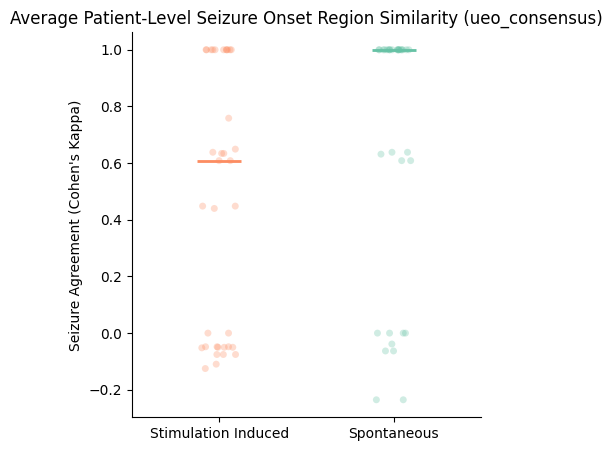

In [45]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'consensus'
for pt,group in annotations_df.groupby("patient"):
    # if sum(group.stim == 0) < 2:
    #     print(f"Skipping {pt} due to insufficient manually annotated spontaneous seizures")
    #     continue
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        all_rs = group.loc[i,'all_rs']
        chs = group.loc[i,f'{annot_type}_{con_type}_rs']
        ch_mask = [r in chs for r in all_rs]
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_{con_type}_rs']
            ch_mask2 = [r in chs2 for r in all_rs]
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))

    # all_stim_annots.append(np.nanmean(stim_kappas))
    # all_spont_annots.append(np.nanmean(spont_kappas))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)

all_stim_annots = [item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])]
all_spont_annots = [item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])]

all_stim_annots = np.array(all_stim_annots)
all_stim_annots = all_stim_annots[~np.isnan(all_stim_annots)]
all_spont_annots = np.array(all_spont_annots)
all_spont_annots = all_spont_annots[~np.isnan(all_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(all_stim_annots),)),np.ones((len(all_spont_annots),))),axis=0)
all_ys = np.concatenate((all_stim_annots,all_spont_annots))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",palette=pal[:2][::-1],
              estimator='median')
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,palette = pal[:2][::-1],alpha=.3)

sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Patient-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(all_stim_annots,all_spont_annots),)

In [30]:
pal = sns.color_palette('Set2')
pal[0]

(0.4, 0.7607843137254902, 0.6470588235294118)